<div id="toc"> </div>

# Import lots of stuff

In [2]:
import sys
sys.path.append('../')

In [3]:
%load_ext autoreload
%autoreload 2

In [20]:
import math
import csv
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import textacy
import textacy.io
import seaborn as sns
from zss import simple_distance
from nltk import Tree
from sklearn import manifold
import scipy.spatial.distance as distance

#from nltk import bigrams
from collections import Counter
#from pycorenlp import StanfordCoreNLP
%matplotlib inline
pd.set_option('display.max_rows', 500)

Use the lg spacy corpus 

In [5]:
import spacy
from spacy.lang.en import English
from spacy.attrs import POS
nlp = spacy.load('en_core_web_lg')

# Preprocess data for analyses

In [6]:
version_to_use = 'tangramsSequential_collapsed'

## Import annotated file & tag

In [7]:
d_raw = pd.read_csv('../data/{}.csv'.format(version_to_use))#.rename(index=str, columns={"contents": "text"})
d_raw['text'] = [nlp(text) for text in d_raw['contents']]

## Run spellchecker (using conservative vectors)

In [8]:
from utils import nlp_utils as utils
conservative_vectors = spacy.load('en_core_web_sm')

In [21]:
print(len(conservative_vectors.vocab))

57852


In [178]:
utils.building_spell_correction_dictionary(
    d_raw.query('taskVersion == "cued"'), 
    conservative_vectors.vocab, 
    []
)

## Get list of all game ids

In [100]:
d = d_raw.copy()

In [101]:
gameidList = pd.unique(d.gameid.ravel()).tolist()
print(gameidList[0:5])
print(len(gameidList))

['0057-414228f8-c268-40d6-9349-b35df4f080d9', '0349-951c1418-40e9-48b3-8290-7ed4461f4d54', '0413-e4a76b36-4367-4e30-abf9-93e823913630', '0461-f522f8f4-37dc-4bb0-89bf-9f6bcf43274a', '0711-b03679d3-9904-4263-bd2f-8ec8e7a45af7']
85


## Get list of all tangram names

In [102]:
tangramList = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L']
print(tangramList)

['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L']


# What are most common words & phrases to reduce? 

Strangely, spacy has no n-gram function, so we use textacy, a convenience wrapper around spacy

In [558]:
d['doc'] = [textacy.Doc(textacy.preprocess_text(row, lowercase = True), lang='en') for row in d['contents']]

KeyboardInterrupt: 

In [84]:
d['unigrams'] = [list(doc.to_terms_list(ngrams=1, as_strings=True, 
                                       normalize = 'lower',filter_stops = False, named_entities = False)) for doc in d['doc']]

d['bigrams'] = [list(doc.to_terms_list(ngrams=2, as_strings=True, 
                                       normalize = 'lower',filter_stops = False, named_entities = False)) for doc in d['doc']]

d['trigrams'] = [list(doc.to_terms_list(ngrams=3, as_strings=True, 
                                       normalize = 'lower',filter_stops = False, named_entities = False)) for doc in d['doc']]

In [88]:
def getCounts(countType, df, gameid, repetitionNum, tangram = None) :
    roundCond = 'repetitionNum == ' + repetitionNum
    gameidCond = 'gameid == "' + gameid + '"'
    if(tangram is not None) :
        tangramCond = 'tangramRef == "' + tangram + '"'
        cond = " and ".join((roundCond, gameidCond, tangramCond))
    else :
        cond = " and ".join((roundCond, gameidCond))
    relevantRow = df.query(cond)
    return Counter([item for sublist in relevantRow[countType]
                    for item in sublist])

for countType in ['unigrams', 'bigrams', 'trigrams'] :
    countDict = Counter([item for sublist in d[countType]
                         for item in sublist])
    wordList = [v for (v,count) in countDict.items() if count > 20]

    with open('outputs/' + countType + 'Counts.csv', 'w') as outfile:
        writer = csv.writer(outfile)
        writer.writerow(['gameid', 'repetitionNum', 'word', 'count'])
        for gameid in gameidList:  
            for repetitionNum in ['1', '2', '3', '4', '5', '6'] :
                counts = getCounts(countType, d, gameid, repetitionNum)
                for word in wordList :
                    writer.writerow([gameid, repetitionNum, word, counts[word]])

# Extract parts of speech

## Get counts for each POS label

In [103]:
tag_dict = {}
for doc in d['text'] :
    for w in doc :
        if w.pos not in tag_dict :
            tag_dict[w.pos_] = w.pos
d['posCounts'] = [doc.count_by(POS) for doc in d['text']]
print(tag_dict)
for posStr in ["NOUN", "DET", "PRON", "VERB", "ADJ", "CCONJ", "ADP"] :
    key_id = tag_dict[posStr]
    d[posStr + 'count'] = [counts[key_id] if key_id in counts else 0 for counts in d['posCounts']]

{'VERB': 99, 'ADP': 84, 'DET': 89, 'NOUN': 91, 'PUNCT': 96, 'ADJ': 83, 'ADV': 85, 'CCONJ': 88, 'NUM': 92, 'SYM': 98, 'PROPN': 95, 'PART': 93, 'INTJ': 90, 'PRON': 94, 'X': 100, 'SPACE': 102}


In [113]:
d['tokens'] = [[element.text for element in l] for l in d['text']]
d['pos'] = [[element.pos_ for element in l] for l in d['text']]
d['noun_chunks'] = [list(l.noun_chunks) for l in d['text']]
d['numWords'] = [len([token for token in l if not token.is_punct]) for l in d['text']]

## Export to csv for plotting in R

In [115]:
(d.drop(["tokens"], 1)
 .to_csv("./outputs/posTagged{}.csv".format(version_to_use), index = False))

# Extract constituency parses

In [50]:
from allennlp.models.archival import load_archive
from allennlp.predictors import Predictor
archive = load_archive(
            "https://s3-us-west-2.amazonaws.com/allennlp/models/elmo-constituency-parser-2018.03.14.tar.gz"
        )
predictor = Predictor.from_archive(archive, 'constituency-parser')

KeyboardInterrupt: 

## Compute edit distances on successive rounds

TODO: it would be nice to use an algorithm like Selkow that uses operations for deleting entire subtrees at once (rather than attaching children to parent, which means that deleting a whole subtree requires as many operations as there are *nodes* in that subtree)

see http://www.aclweb.org/anthology/R13-1002 for a way of altering ZS output

In [51]:
def label_distance (label1, label2) :
    if label1 == label2 :
        return 0
    else :
        return 1

def get_root(doc) :
    asdf = dict(('label' if key == 'nodeType' else key, value) for (key, value) in doc.items())
    return asdf

def get_children(subtree) :
    if 'children' in subtree.keys() :
        return [dict(('label' if key == 'nodeType' else key, value) for (key, value) in d.items()) for d in subtree['children']]
    else :
        return []

def get_label(node) :
    return node['label']

def edit_distance(tree1, tree2, return_operations = False) :
    return simple_distance(get_root(tree1), get_root(tree2), 
                           get_children, get_label, label_distance, return_operations=return_operations)

def example() :
    s1 = predictor.predict_json({"sentence": "I am a cat with a big bone"})
    s2 = predictor.predict_json({"sentence": "I am a cat"})
    ed = edit_distance(s1['hierplane_tree']['root'], s2['hierplane_tree']['root'], return_operations=True)
    print('tree1:', Tree.fromstring(s1['trees']))
    print('tree2:', Tree.fromstring(s2['trees']))
    print('operations:', ed[1])
    print('cost:', ed[0])

Ideally, we could use an algorithm that would give a cost of 1 for this example

In [53]:
from IPython.display import clear_output

tiny_d = d[['gameid', 'repetitionNum', 'contents', 'intendedName']]
parses = []
for i, s in enumerate(tiny_d['contents']) :
    clear_output(wait=True)
    print(i, '/', len(tiny_d['contents']))
    parses.append(predictor.predict_json({'sentence' : s})['hierplane_tree']['root'])
tiny_d['tree_parse'] = parses

5288 / 5289


/Users/rxdh/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [69]:
def finditem(obj, value, initLevel = True):
    if obj['nodeType'] == value and not initLevel:
        return True
    elif 'children' in obj :
        for child in obj['children'] :
            item = finditem(child, value, initLevel = False)
            if item is not None:
                return item
tiny_d['SBAR'] = [finditem(s, 'SBAR') for s in tiny_d['tree_parse']]
tiny_d['PP'] = [finditem(s, 'PP') for s in tiny_d['tree_parse']]
tiny_d['CC'] = [finditem(s, 'CC') for s in tiny_d['tree_parse']]

In [71]:
tiny_d.to_json('./outputs/constituency_parses.json')
tiny_d.drop('tree_parse', 1).to_csv('./outputs/constituency_tags.csv')

In [72]:
tiny_d = pd.read_json('./outputs/constituency_parses.json')

In [58]:
gameids = np.unique(tiny_d['gameid'])
tangramids = np.unique(tiny_d['intendedName'])

transitions = np.zeros([len(gameids), len(tangramids) ,5])
for i, gameid in enumerate(gameids) :
    clear_output(wait=True)
    print(i, '/', len(gameids))
    game_d = tiny_d.query('gameid == "{0}"'.format(gameid))
    for j, intendedName in enumerate(tangramids) :
        for k, init_occurrenceNum in enumerate(range(1,6)) :
            dist = []
            sub1 = game_d.query('intendedName == "{0}" and repetitionNum == {1}'.format(intendedName, init_occurrenceNum))['tree_parse']
            sub2 = game_d.query('intendedName == "{0}" and repetitionNum == {1}'.format(
                intendedName, init_occurrenceNum+1
            ))['tree_parse']
            for tree1 in sub1 :
                for tree2 in sub2 :
                    dist.append(edit_distance(tree1, tree2))
            transitions[i, j, k] = np.max(dist) if dist else np.nan

84 / 85


TODO: normalized by tree size
TODO: maybe can show this more straightforward by doing permutation test thing on POS tags instead of words

In [59]:
np.nanmean(transitions, axis=0)

array([[26.04878049, 14.14492754,  8.90322581,  5.03333333,  3.82142857],
       [32.39506173, 19.        , 12.67164179,  8.75757576,  6.58730159],
       [17.92957746,  7.703125  ,  4.77192982,  2.32142857,  2.25925926],
       [23.31325301, 12.5       ,  8.89552239,  4.03125   ,  3.19354839],
       [19.45333333,  9.84057971,  5.328125  ,  3.        ,  1.98214286],
       [19.46987952, 13.31168831,  6.64473684,  5.        ,  2.95774648],
       [33.05063291, 21.13513514, 10.89552239,  7.02985075,  5.76190476],
       [26.93975904, 12.44303797,  6.36486486,  4.43661972,  3.73134328],
       [25.        , 13.98666667,  8.84848485,  6.33333333,  4.16071429],
       [26.02409639, 14.91025641,  7.43243243,  4.54285714,  3.43478261],
       [31.90361446, 17.74074074, 12.24358974,  7.64935065,  7.22535211],
       [23.54878049, 15.30769231,  9.80519481,  6.72      ,  4.51388889]])

### Across-game version
Instead of looking at edit distance from round $i$ to $i + 1$ for pair $j$, we look at average edit distances between pairs $j$ to $j+1$ on round $i$.

In [60]:
import random
print(random.sample([1,2], len([1,2])))

[2, 1]


In [61]:
acrossgame = np.zeros([len(tangramids),6, len(gameids)])
shuffled_gameids = random.sample(list(gameids), len(gameids))
for i, intendedName in enumerate(tangramids) :
    clear_output(wait=True)
    print(i, '/', len(tangramids))
    for repetitionNum in range(1,7) :
        mini_d = tiny_d.query('intendedName == "{0}" and repetitionNum == {1}'.format(intendedName, repetitionNum))      
        for k in range(len(gameids) -1) :
            dist = []
#            print(gameids[k], 'to', gameids[k+1])
            sub1 = mini_d.query('gameid == "{0}"'.format(gameids[k]))['tree_parse']
            sub2 = mini_d.query('gameid == "{0}"'.format(gameids[k+1]))['tree_parse']
            for tree1 in sub1 :
                for tree2 in sub2 :
                    dist.append(edit_distance(tree1, tree2))
#             print(sub1)
#             print(sub2)
            acrossgame[i, repetitionNum-1, k] = np.max(dist) if dist else np.nan

11 / 12


In [62]:
np.nanmean(acrossgame, axis=2)

array([[35.89411765, 22.01265823, 18.07017544, 11.91111111, 11.        ,
        10.18918919],
       [40.97647059, 27.67532468, 20.2238806 , 14.43636364, 13.42105263,
        10.95918367],
       [24.05      , 13.85245902, 11.9375    ,  7.64705882,  6.48571429,
         7.        ],
       [30.27710843, 19.46987952, 15.47540984, 10.45283019,  9.33333333,
         8.93617021],
       [26.1625    , 17.85294118, 11.7       ,  7.66037736,  6.35416667,
         5.73170732],
       [27.75294118, 19.59259259, 13.22972973, 12.46376812,  9.64516129,
         9.28333333],
       [39.5       , 28.62337662, 18.86153846, 14.875     , 12.98113208,
        10.86      ],
       [36.38554217, 21.48192771, 14.47945205, 11.296875  , 10.25862069,
         8.53703704],
       [32.92771084, 21.58227848, 15.        , 11.40816327, 11.95454545,
        10.02777778],
       [32.11111111, 22.84337349, 14.97183099, 13.23529412,  9.84210526,
         9.0862069 ],
       [41.49411765, 26.32098765, 20.93670886, 14.

# Calculate indicator words for tangrams/rounds

## First, get list of words in first round

In [ ]:
# Filter down to first round
d_round1 = d[d['occurrenceNum'] == 1]

# Pull out all tokens and collapse into count dict
tokenDict = Counter([item for sublist in d_round1['tokens'].tolist()
                     for item in sublist])
# Pull out all words that occur more than once
wordList = [word for (word,count) in tokenDict.items() if count > 1 and not word.isdigit()]
print(wordList[0:10])
print(len(wordList))

# Get POS map; will be longer because it doesn't require count > 1, but it doesn't matter
POSdict = {word: POS for lemma in d_round1['lemmas'] for (word, POS) in lemma}
print(len(POSdict.keys()))

## Helper functions to select words & counts

In [ ]:
def getWordCounts(df, gameid, occurrenceNum, tangram = None) :
    roundCond = 'occurrenceNum == ' + occurrenceNum
    gameidCond = 'gameid == "' + gameid + '"'
    if(tangram is not None) :
        tangramCond = 'intendedObj == "' + tangram + '"'
        cond = " and ".join((roundCond, gameidCond, tangramCond))
    else :
        cond = " and ".join((roundCond, gameidCond))
    relevantRow = df.query(cond)
    return Counter([item for sublist in relevantRow['tokens'].tolist() 
                    for item in sublist])

#creates mini dataframe that grabs the words used in round n for a given tangram and gameid
def selectTangramRoundWords(df, tangram, roundNum, gameid):
    wordCounts = getWordCounts(df, gameid, roundNum, tangram)
    return list(wordCounts.keys())

## Helper function to compute PMIs

Note that merging is really costly -- if we need to speed it up, this might be the first target. Can also vectorize the log operation.

In [ ]:
#returns a table with the all words above 0 PMI and their counts for a given tangram
#calculate the probability for words given tangram A ------ p(x|y)
def makeMyPMI(df, tangram, roundNum, gameid, totals):

    # count words w/in tangram
    tangramCounts = getWordCounts(df, gameid, roundNum, tangram)

    #total number of words 
    tangramNumWords = (1 if sum(tangramCounts.values()) == 0 
                       else sum(tangramCounts.values()))

    #dataframe to compare 
    indicatorDF = pd.merge(pd.DataFrame(list(tangramCounts.items()), columns=['word', 'count']),
                           pd.DataFrame(list(totals["counts"].items()), columns=['word', 'totalCount']),
                           on='word', how = 'inner')

    #calculate PMI without log first. Having trouble with float issues. 
    indicatorDF['roughPMI'] = ((indicatorDF['count']/tangramNumWords)
                                / (indicatorDF['totalCount']/totals["numWords"]))
    indicatorDF['logPMI'] = [math.log10(num) for num in indicatorDF['roughPMI']]
    
    #remove column rough PMI
    indicatorDF = indicatorDF.drop('roughPMI', 1)
    
    return indicatorDF

## Write out PMIs & matching rates for all words

Note that we do a sloppy optimization by only computing total counts once and only when necessary 

In [ ]:
def memoize(d, gameid, counts) : 
    if "counts" not in counts : 
        counts["counts"] = getWordCounts(d, gameid, "1")
        counts["numWords"] = float(sum(counts["counts"].values()))
        return counts
    else :
        return counts

with open('outputs/sequential_matchAndPMI.csv', 'a', newline='') as outfile:
    writer = csv.writer(outfile)
    writer.writerow(['word', 'POS', 'match', 'pmi', 'total'])
    for word in wordList :
        print(word + ":" + POSdict[word])
        pmi = 0
        match = 0
        total = 0
        for gameid in gameidList:  
            memoizedCounts = {}
            for tangram in tangramList:
                memoizedCounts = memoize(d, gameid, memoizedCounts)
                round1WordList = selectTangramRoundWords(d, tangram, "1", gameid)
                total = total + 1 if word in round1WordList else total
                if word in round1WordList :
                    PMI_df = makeMyPMI(d, tangram, "1", gameid, memoizedCounts)
                    pmi = pmi + PMI_df[PMI_df['word'] == word]['logPMI'].tolist()[0]
                    round6WordList = selectTangramRoundWords(d, tangram, "6", gameid)
                    match = (match + 1 if (word in round1WordList and word in round6WordList)
                             else match)
        writer.writerow([word, POSdict[word], float(match) / float(total), pmi/total, total])


Also write out raw word counts on each round (so we can see what most likely words to be dropped are).

In [ ]:
for row in d :
    print row

TODO: exclude numbers earlier in the pipeline, 

TODO: don't average over matches and pmis

In [ ]:
numSamples = 1000

#grab words with highestPMI for a given tangram/gameid
def highestPMIWords(d, tangram, roundNum, gameid):
    allTangramCounts = {}
    allTangramCounts['counts'] = getWordCounts(d, gameid, "1")
    allTangramCounts['numWords'] = float(sum(allTangramCounts["counts"].values()))

    PMIdf = (makeMyPMI(d, tangram, roundNum, gameid, allTangramCounts))

    # Remove numbers
    PMIdf['POS'] = [POSdict[word] for word in PMIdf['word']]
    PMIdf = PMIdf.query('POS != "CD"'.format())

    #if PMIdf has words, pull out max values, it is empty return it as is
    if len(PMIdf.index) > 0:
        PMI_values = PMIdf.logPMI.unique()
        maxPMI = PMI_values.max()
        PMIdf = PMIdf.loc[PMIdf['logPMI'] == maxPMI]
        PMIdfword = PMIdf['word']
        return PMIdfword.tolist()
    else: 
        return PMIdf

with open('outputs/PMIbootstrap.csv', 'w', newline='') as outfile:
    writer = csv.writer(outfile)
    writer.writerow(['sampleNum', 'tangram', 'gameid', 'numCandidates', 'match', 'highest'])
    for gameid in gameidList :
        for tangram in tangramList :
            round1Words = selectTangramRoundWords(d, tangram, "1", gameid)
            if len(round1Words) > 0:
                # First, write highest PMI match
                highPMIWords = highestPMIWords(d, tangram, "1", gameid)
                round6Words = selectTangramRoundWords(d, tangram, "6", gameid)
                match = np.mean([1 if word in round6Words else 0 for word in highPMIWords ])
                writer.writerow([0, tangram, gameid, len(highPMIWords), match, "highest"])

                # Next, take a bunch of null samples
                for i in range(numSamples) :
                    randomWord = np.random.choice(round1Words)
                    match = np.mean([1 if randomWord in round6Words else 0])
                    writer.writerow([i + 1, tangram, gameid, 1, match, "null"])

# Examine semantic embeddings

We'd like to pull out bag of words embeddings from NPs in each utterance in the cued dataset and cluster them for each tangram; expect to see different pairs in different parts of the space (i.e. to compute a d' for an 'idiosyncracy' or 'multiple equilibria' result) and also different utterances from single games closer together. 

In [119]:
embedding_meta = (d
#               .query("taskVersion == 'cued' and role == 'director'")
               .sort_values(by = ['gameid', 'intendedName', 'repetitionNum'])
               .loc[:, ['gameid', 'intendedName', 'repetitionNum', 'text']])

In [120]:
asdf = np.array([]).reshape(0, 300)
if asdf.size > 0 :
    print('woo')

In [133]:
meta = pd.DataFrame(columns = ['gameid', 'intendedName', 'repetitionNum', 'empty'])
feats = np.array([]).reshape(0, 300)

for name, group in (embedding_meta.groupby(['gameid', 'intendedName', 'repetitionNum'], as_index=False)) :
    embedding = np.array([]).reshape(0, 300)
    for doc in group.text :
        for token in doc :
            if token.pos_ in ['NOUN', 'VERB', 'ADJ'] and token.has_vector :
                embedding = np.vstack((embedding, token.vector))
    is_empty = embedding.size == 0
    if is_empty :
        print(group.text)
    new_df = pd.DataFrame([list(name) + [is_empty]], columns = ['gameid', 'intendedName', 'repetitionNum', 'empty'])
    meta = meta.append(new_df, ignore_index=True)
    feats = np.vstack((feats, np.nanmean(embedding, axis = 0)))

60    (indiana)
Name: text, dtype: object


/Users/rxdh/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: Mean of empty slice
  from ipykernel import kernelapp as app


1042    (leo)
Name: text, dtype: object
1514    (jesus)
Name: text, dtype: object
1517    (jesus)
Name: text, dtype: object
1536    (jesus)
Name: text, dtype: object
1753    (y)
Name: text, dtype: object
2091    (back, right)
Name: text, dtype: object
2095    (back, right)
Name: text, dtype: object
2113    (back, right)
Name: text, dtype: object
2450    (frankenstein)
Name: text, dtype: object
3630    (frankenstein)
Name: text, dtype: object
3641    (frankenstein)
Name: text, dtype: object
3657    (frankenstein)
Name: text, dtype: object
3667    (frankenstein)
Name: text, dtype: object
4058    (', >, ', right)
Name: text, dtype: object
4163    (mister, fed, ex)
Name: text, dtype: object
4185    (minnesota)
Name: text, dtype: object
4193    (minnesota)
Name: text, dtype: object
4211    (minnesota)
Name: text, dtype: object
4216    (minnesota)
Name: text, dtype: object
4234    (minnesota)
Name: text, dtype: object
4254    (YMCA)
Name: text, dtype: object
4263    (YMCA)
Name: text, dtype:

In [122]:
meta = pd.DataFrame(columns = ['gameid', 'intendedName', 'repetitionNum', 'empty'])
feats = np.array([]).reshape(0, 300)

for name, group in (embedding_meta.groupby(['gameid', 'intendedName', 'repetitionNum'], as_index=False)) :
    embedding = np.array([]).reshape(0, 300)
    for doc in group.text :
        for token in doc :
            if token.pos_ in ['NOUN', 'VERB', 'ADJ'] and token.has_vector :
                embedding = np.vstack((embedding, token.vector))
    is_empty = embedding.size == 0
    if is_empty
    new_df = pd.DataFrame([list(name) + [is_empty]], columns = ['gameid', 'intendedName', 'repetitionNum', 'empty'])
    meta = meta.append(new_df, ignore_index=True)
    feats = np.vstack((feats, np.nanmean(embedding, axis = 0)))

,gameid,intendedName,repetitionNum,empty
0,0057-414228f8-c268-40d6-9349-b35df4f080d9,A,1,False
1,0057-414228f8-c268-40d6-9349-b35df4f080d9,A,2,False
2,0057-414228f8-c268-40d6-9349-b35df4f080d9,A,3,False
3,0057-414228f8-c268-40d6-9349-b35df4f080d9,A,4,False
4,0057-414228f8-c268-40d6-9349-b35df4f080d9,A,5,False
5,0057-414228f8-c268-40d6-9349-b35df4f080d9,A,6,False
6,0057-414228f8-c268-40d6-9349-b35df4f080d9,B,1,False
7,0057-414228f8-c268-40d6-9349-b35df4f080d9,B,2,False
8,0057-414228f8-c268-40d6-9349-b35df4f080d9,B,3,False
9,0057-414228f8-c268-40d6-9349-b35df4f080d9,B,4,False


In [123]:
assert(feats.shape[0] == meta.shape[0])

TODO: do we really only want to use nouns? or all words in noun_chunks?

TODO: do for rest of tangrams

TODO: check whether *tangrams* cluster together?

In [124]:
## save stuff out so just in case we mess up it's okay
meta.to_csv('outputs/meta_tangrams_embeddings.csv')
np.save('outputs/feats_tangrams_embeddings.npy',feats)

In [125]:
meta = pd.read_csv('outputs/meta_tangrams_embeddings.csv')
feats = np.load('outputs/feats_tangrams_embeddings.npy')

In [126]:
## for each tangram, grab feats from all games and get distance matrix
tangram_ids = np.unique(meta.intendedName.values)

this_tangram = tangram_ids[0]

this_meta = meta[meta['intendedName']==this_tangram]
print(this_meta)
tangram_inds = np.array(this_meta.index)
these_feats = feats[tangram_inds,:]

## get distance matrix for this tangram
dist_mat = distance.pdist(these_feats, metric='euclidean') ## or some other distance metric
dist_mat_sq = distance.squareform(dist_mat)

## then for each game, compare the within-game distances to the distances to utts from a different game
## yielding, for each pair of games, a measure of the extent to which the within-game distances are SMALLER
## than the between-game distances

## handy experiment parameters
num_reps_per_game = len(np.unique(meta.repetitionNum.values))
print(dist_mat_sq.shape)
print(num_reps_per_game)
assert dist_mat_sq.shape[0]%num_reps_per_game==0 ## check ot make sure that this is divisible by the number of reps in each game
num_games = int(dist_mat_sq.shape[0]/num_reps_per_game)

      Unnamed: 0                                     gameid intendedName  \
0              0  0057-414228f8-c268-40d6-9349-b35df4f080d9            A   
1              1  0057-414228f8-c268-40d6-9349-b35df4f080d9            A   
2              2  0057-414228f8-c268-40d6-9349-b35df4f080d9            A   
3              3  0057-414228f8-c268-40d6-9349-b35df4f080d9            A   
4              4  0057-414228f8-c268-40d6-9349-b35df4f080d9            A   
5              5  0057-414228f8-c268-40d6-9349-b35df4f080d9            A   
72            72  0349-951c1418-40e9-48b3-8290-7ed4461f4d54            A   
73            73  0349-951c1418-40e9-48b3-8290-7ed4461f4d54            A   
74            74  0349-951c1418-40e9-48b3-8290-7ed4461f4d54            A   
75            75  0349-951c1418-40e9-48b3-8290-7ed4461f4d54            A   
76            76  0349-951c1418-40e9-48b3-8290-7ed4461f4d54            A   
77            77  0349-951c1418-40e9-48b3-8290-7ed4461f4d54            A   
144         

In [127]:
# ## loop through game_inds
# for game_ind1 in range(len(gameids)):
#     for game_ind2 in range(game_ind1, len(gameids)):
        
dist_ratio = []
for game_ind in np.arange(num_games):
    # extract the within-game distances
    lb = game_ind * num_reps_per_game
    ub = (game_ind+1) * num_reps_per_game
    within_game_dist_block = dist_mat_sq[lb:ub,lb:ub]

    ## get the indices of the upper triangle of this block
    triu_inds = np.triu_indices(num_reps_per_game,k=1)
    ## now grab actual distances 
    within_game_dists = within_game_dist_block[triu_inds]

    ## loop through game_inds again to get between-game distances
    other_games = [i for i in np.arange(num_games) if i != game_ind]
    
    _dist_ratio = [] ## initialize the dist ratio list for this game_ind
    for this_other_game_ind in other_games:

        ## get indices for the other game
        lbo = this_other_game_ind * num_reps_per_game
        ubo = (this_other_game_ind+1) * num_reps_per_game

        ## now, extract the between-game distances
        between_game_dist_block = dist_mat_sq[lb:ub,lbo:ubo]
        between_game_dists = np.ravel(between_game_dist_block)
        assert len(between_game_dists)==num_reps_per_game**2 ## so here there really should be 36 distances to consider

        ## doop, derp, um, we could compute the ratio? um
        avg_within_game_dist = np.mean(within_game_dists)
        avg_between_game_dist = np.mean(between_game_dists)
        _dist_ratio.append(avg_within_game_dist/avg_between_game_dist)
        
    ## tack on your list of dist ratios for this game_ind onto your cumulative dist_ratio list of lists
    dist_ratio.append(_dist_ratio)

In [128]:
dist_ratio = np.array(dist_ratio)
agg_dr = np.nanmean(dist_ratio,axis=1)

/Users/rxdh/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: Mean of empty slice
  


TODO: initial distribution w/in vs. across
TODO: variance across pairs at beginning & end
TODO: 2D PCA... (traces of beginnings and ends)
-- Connect individuals in a game with a line!
-- Word clouds for initial and final

Text(0,0.5,'count')

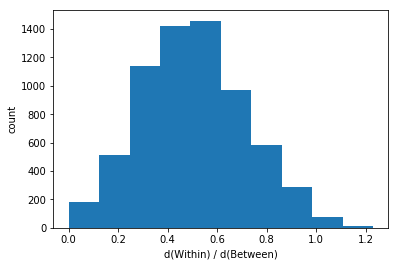

In [129]:
def remove_nans(x):
    return [i for i in x if not np.isnan(i)]
    
x = remove_nans(np.ravel(dist_ratio))
plt.hist(x)
plt.xlabel('d(Within) / d(Between)')
plt.ylabel('count')

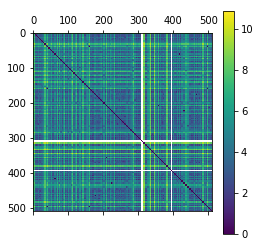

In [130]:
plt.matshow(dist_mat_sq)
plt.colorbar()

# Look at tsne visualization

TODO: there are a bunch of problems with this: a lot of the creative utterances don't exist in current embedding (e.g. "ghostman"), sometimes they don't converge to a noun (e.g. "flying"), etc.

In [131]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.manifold import MDS
from sklearn.decomposition import TruncatedSVD
tsne = TSNE(n_components = 2)
big_pca = PCA(n_components = 50)
viz_pca = PCA(n_components = 2)
mds = MDS(n_components=2)

In [132]:
embedding_viz = pd.DataFrame(
    columns = ['gameid', 'intendedName', 'repetitionNum', 'x_tsne', 'y_tsne', 'x_mds', 'y_mds']
)

for name, group in meta.query('not empty').drop(['Unnamed: 0', 'empty'], 1).groupby('intendedName') :
    tangram_inds = np.array(group.index)
    X = feats[tangram_inds]
    X_mds = pd.DataFrame(mds.fit_transform(X), 
                     columns = ['x_mds', 'y_mds'], 
                     index=group.index)

    X_tsne = pd.DataFrame(tsne.fit_transform(big_pca.fit_transform(X)), 
                         columns = ['x_tsne', 'y_tsne'], 
                         index=group.index)
    embedding_viz = embedding_viz.append(pd.concat([group, X_tsne, X_mds], axis = 1), 
                         ignore_index=True)

In [135]:
embedding_viz.to_csv('outputs/embeddings.csv')

TODO: compare cosine similarity distances with-in vs. across games?

TODO: compare variance across games at beginning and end